In [1]:
from time import time
import os
import warnings
import numpy as np
from random import shuffle
from skimage.data import imread
from skimage.transform import resize
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, GlobalMaxPooling2D
from keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.regularizers import l2
from keras.utils.np_utils import to_categorical
from keras.optimizers import adam
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score, accuracy_score, log_loss
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [2]:
warnings.filterwarnings('ignore')
t0 = time()
print('Loading Images')
image = []
path = 'classification_data'
n = 7  # dummy declaration
j = 0
(img_len, img_wid) = (64, 64)
for filename in os.listdir(path):
    img = imread(os.path.join(path, filename))
    img = resize(img, (img_len, img_wid))
    for i, s in enumerate(filename):
        if s is '_':
            n = int(filename[0:i])
    image.append([img, n])

shuffle(image)
labels = []
image1 = []
for i in range(len(image)):
    labels.append(image[i][1])
    image1.append(image[i][0])
label = LabelEncoder().fit_transform(labels)

print('Time to load the images  :   %0.2f sec' % (time() - t0))

print('Split into train and test batches images')
image1 = np.asarray(image1)
X_train, X_test, y_train, y_test = train_test_split(image1, label, test_size=0.2)

print(X_train.shape)

Loading Images
Time to load the images  :   112.29 sec
Split into train and test batches images
(2447, 64, 64, 3)


In [9]:
def classifier_fun():
    print('Load the classifier function and build the model')
    clf = Sequential()
    clf.add(BatchNormalization(input_shape=(img_len, img_wid, 3)))
    clf.add(Conv2D(32, (3, 3), activation='relu', bias_initializer='glorot_normal', kernel_regularizer=l2(0.01), padding='same'))
    clf.add(Conv2D(32, (3, 3), activation='relu', bias_initializer='glorot_normal', kernel_regularizer=l2(0.01), padding='same'))
    clf.add(MaxPooling2D())
    clf.add(Conv2D(64, (3, 3), activation='relu', bias_initializer='glorot_normal', kernel_regularizer=l2(0.01), padding='same'))
    clf.add(Conv2D(64, (3, 3), activation='relu', bias_initializer='glorot_normal', kernel_regularizer=l2(0.01), padding='same'))
    clf.add(MaxPooling2D())
    clf.add(Conv2D(128, (3, 3), activation='relu', bias_initializer='glorot_normal', kernel_regularizer=l2(0.01), padding='same'))
    clf.add(MaxPooling2D())
    clf.add(Flatten())
    clf.add(BatchNormalization())
    clf.add(Dense(64, activation='relu', bias_initializer='glorot_normal'))
    clf.add(Dropout(0.2))
    clf.add(Dense(units=5, activation='softmax', bias_initializer='glorot_normal'))
    
    opt = adam(lr=0.001)
    clf.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    clf.summary()

    return clf

print('Call the classifier function')
model = classifier_fun()

Call the classifier function
Load the classifier function and build the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_4 (Batch (None, 64, 64, 3)         12        
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 64)        36928     
________________________________________________________________

In [10]:
t0 = time()
stop = EarlyStopping(monitor='val_loss', patience=15, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-8)

his = model.fit(X_train, to_categorical(y_train, 5), epochs=100, batch_size=24, callbacks=[reduce_lr, stop], validation_split=0.3)
print('Time to train the classifier  :   %0.2f sec' % (time() - t0))

Train on 1712 samples, validate on 735 samples
Epoch 1/100
1712/1712 [==============================] - 70s - loss: 3.7742 - categorical_accuracy: 0.2839 - val_loss: 3.8675 - val_categorical_accuracy: 0.1946
Epoch 2/100
1712/1712 [==============================] - 70s - loss: 2.7648 - categorical_accuracy: 0.3814 - val_loss: 2.8697 - val_categorical_accuracy: 0.1905
Epoch 3/100
1712/1712 [==============================] - 70s - loss: 2.3247 - categorical_accuracy: 0.4661 - val_loss: 2.7525 - val_categorical_accuracy: 0.2014
Epoch 4/100
1712/1712 [==============================] - 73s - loss: 2.0475 - categorical_accuracy: 0.4860 - val_loss: 3.0079 - val_categorical_accuracy: 0.1891
Epoch 5/100
1712/1712 [==============================] - 70s - loss: 1.8368 - categorical_accuracy: 0.5199 - val_loss: 3.8957 - val_categorical_accuracy: 0.1932
Epoch 6/100
1712/1712 [==============================] - 73s - loss: 1.6545 - categorical_accuracy: 0.5461 - val_loss: 2.2260 - val_categorical_accu

1712/1712 [==============================] - 70s - loss: 0.3000 - categorical_accuracy: 0.9655 - val_loss: 0.5379 - val_categorical_accuracy: 0.9156
Epoch 52/100
1712/1712 [==============================] - 70s - loss: 0.2918 - categorical_accuracy: 0.9685 - val_loss: 0.4887 - val_categorical_accuracy: 0.9374
Epoch 53/100
1712/1712 [==============================] - 72s - loss: 0.2760 - categorical_accuracy: 0.9796 - val_loss: 0.4998 - val_categorical_accuracy: 0.9333
Epoch 54/100
1712/1712 [==============================] - 70s - loss: 0.2887 - categorical_accuracy: 0.9755 - val_loss: 0.4881 - val_categorical_accuracy: 0.9415
Epoch 55/100
1712/1712 [==============================] - 70s - loss: 0.2760 - categorical_accuracy: 0.9784 - val_loss: 0.4931 - val_categorical_accuracy: 0.9306
Epoch 56/100
1712/1712 [==============================] - 70s - loss: 0.2761 - categorical_accuracy: 0.9819 - val_loss: 0.4755 - val_categorical_accuracy: 0.9429
Epoch 57/100
1712/1712 [=================

In [13]:
print('Prediction of Test data')
ytest_label = to_categorical(y_test, 5)
y_prob = model.predict(X_test, batch_size=24)
print('\n Area under PR curve  =  ',
      average_precision_score(y_true=ytest_label, y_score=y_prob, average='weighted'))
print('\n Area under ROC curve  =  ',
      roc_auc_score(y_true=ytest_label, y_score=y_prob, average='weighted'))
print('\n Log_loss = ', log_loss(ytest_label, y_prob))

y = (y_prob > 0.5)

print('\n f1-score  =  ', f1_score(y_true=ytest_label, y_pred=y, average='weighted'))
print('\n Accuracy  =  ', accuracy_score(y_true=ytest_label, y_pred=y))



Prediction of Test data

 Area under PR curve  =   0.961049697587

 Area under ROC curve  =   0.983748589022

 Log_loss =  0.419003680618

 f1-score  =   0.920569196721

 Accuracy  =   0.915032679739


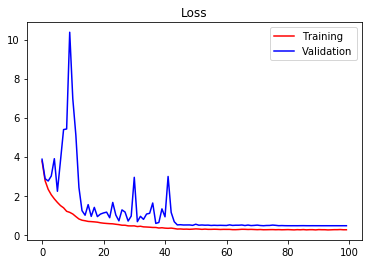

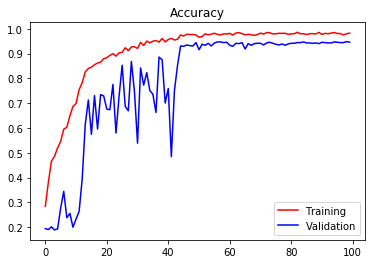

In [12]:
# Plots
x_plot = np.arange(len(his.epoch))
plt.figure(1)
plt.title('Loss')
plt.plot(x_plot, his.history['loss'], 'r', label='Training')
plt.plot(x_plot, his.history['val_loss'], 'b', label='Validation')
plt.legend()
plt.show()

plt.figure(2)
plt.title('Accuracy')
plt.plot(x_plot, his.history['categorical_accuracy'], 'r', label='Training')
plt.plot(x_plot, his.history['val_categorical_accuracy'], 'b', label='Validation')
plt.legend()
plt.show()
